In [13]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv(r"C:\Users\drgee\Desktop\GUVI\Crop Production Prediction Project\FAOSTAT_data - FAOSTAT_data_en_12-29-2024.csv").dropna(how='all').drop(columns='Note')

### Data Preprocessing 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224647 entries, 0 to 224646
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Domain Code       224647 non-null  object 
 1   Domain            224647 non-null  object 
 2   Area Code (M49)   224647 non-null  int64  
 3   Area              224647 non-null  object 
 4   Element Code      224647 non-null  int64  
 5   Element           224647 non-null  object 
 6   Item Code (CPC)   224642 non-null  object 
 7   Item              224647 non-null  object 
 8   Year Code         224647 non-null  int64  
 9   Year              224647 non-null  int64  
 10  Unit              224645 non-null  object 
 11  Value             218130 non-null  float64
 12  Flag              224643 non-null  object 
 13  Flag Description  224634 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 24.0+ MB


In [16]:
df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2019,2019,ha,29203.0,A,Official figure
1,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2019,2019,kg/ha,1308.3,A,Official figure
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1371,"Almonds, in shell",2019,2019,t,38205.0,A,Official figure
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2020,2020,ha,22134.0,A,Official figure
4,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2020,2020,kg/ha,1775.9,A,Official figure


In [17]:
df = df[[
#   'Domain Code', 
    'Domain', 
# 'Area Code (M49)', 
    'Area', 
# 'Element Code',
       'Element', 
    #    'Item Code (CPC)', 
    'Item', 
    # 'Year Code', 
    'Year', 'Unit',
       'Value', 'Flag', 
    #    'Flag Description'
    ]].copy()

df.head()

,Domain,Area,Element,Item,Year,Unit,Value,Flag
0,Crops and livestock products,Afghanistan,Area harvested,"Almonds, in shell",2019,ha,29203.0,A
1,Crops and livestock products,Afghanistan,Yield,"Almonds, in shell",2019,kg/ha,1308.3,A
2,Crops and livestock products,Afghanistan,Production,"Almonds, in shell",2019,t,38205.0,A
3,Crops and livestock products,Afghanistan,Area harvested,"Almonds, in shell",2020,ha,22134.0,A
4,Crops and livestock products,Afghanistan,Yield,"Almonds, in shell",2020,kg/ha,1775.9,A


In [18]:
df.isnull().sum() 

Domain        0
Area          0
Element       0
Item          0
Year          0
Unit          2
Value      6517
Flag          4
dtype: int64

In [19]:
df.columns

Index(['Domain', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value', 'Flag'], dtype='object')

In [20]:
nan_units = df[df['Unit'].isna()].copy()

In [22]:
for index, row in nan_units.iloc[:, 1:4].iterrows():
    correct_unit = df.loc[
    (df['Area'] == row['Area']) &
    (df['Item'] == row['Item']) &
    (df['Element'] == row['Element']) &
    (df['Unit'].notna()),
    'Unit'
].iloc[0]
    
    print(correct_unit)
    print(index)
    df.at[index, 'Unit'] = correct_unit


t
259
kg/ha
283


In [23]:
nan_flags = df[df['Flag'].isna()].copy()
nan_flags
nan_flags.loc[:, ['Area','Element','Item','Unit']]

,Area,Element,Item,Unit
232,Afghanistan,Stocks,Goats,An
235,Afghanistan,Stocks,Goats,An
239,Afghanistan,Production,Grapes,t
243,Afghanistan,Area harvested,Grapes,ha


In [24]:
for index, row in nan_flags.loc[:, ['Area','Element','Item','Unit']].iterrows():
    correct_flag = df.loc[
    (df['Area'] == row['Area']) &
    (df['Item'] == row['Item']) &
    (df['Element'] == row['Element']) &
    (df['Unit'] == row['Unit']) &
    (df['Flag'].notna()), 'Flag'].iloc[0]
    
    print(correct_flag)
    print(index)
    df.at[index, 'Flag'] = correct_flag

E
232
E
235
A
239
A
243


In [25]:
df['Value'] = df['Value'].fillna(
    df.groupby(['Item', 'Year', 'Element', 'Unit'])['Value'].transform('mean')
)

In [26]:
df.loc[(df['Flag'] == 'M'), 'Value'] = 0

### Creating Crop Production Table

In [27]:
!pip install psycopg2

Defaulting to user installation because normal site-packages is not writeable


In [28]:
from sqlalchemy import create_engine
import psycopg2

host = "localhost"
port = "5432"
database = "Crop_Prediction"
username = "postgres"
password = "password"

In [29]:
df.columns = [col.lower() for col in df.columns]

In [30]:
# connection = psycopg2.connect(
#     dbname=database, user=username, password=password, host=host, port=port
# )
# cursor = connection.cursor()

# cursor.execute("""
#     CREATE TABLE crop_production (
#     domain    TEXT,
#     area      TEXT,
#     element   TEXT,
#     item      TEXT,
#     year      INTEGER,
#     unit      TEXT,
#     value     FLOAT,
#     flag      TEXT
# )
# """)

# connection.commit()
# cursor.close()
# connection.close()


# print("Table created!")

### Inserting data into the Table

In [31]:
# engine_string = f"postgresql://{username}:{password}@{host}:{port}/{database}"
# engine = create_engine(engine_string)

# df.to_sql('crop_production', engine, if_exists='append', index=False)

# print("Data successfully pushed to PostgreSQL!")

### Data Visualization and Analysis

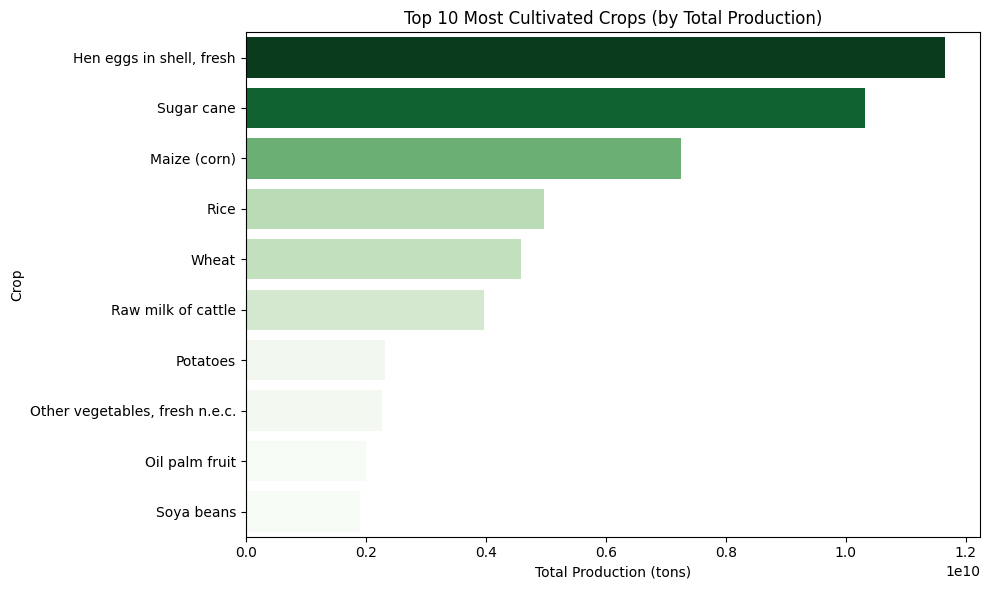

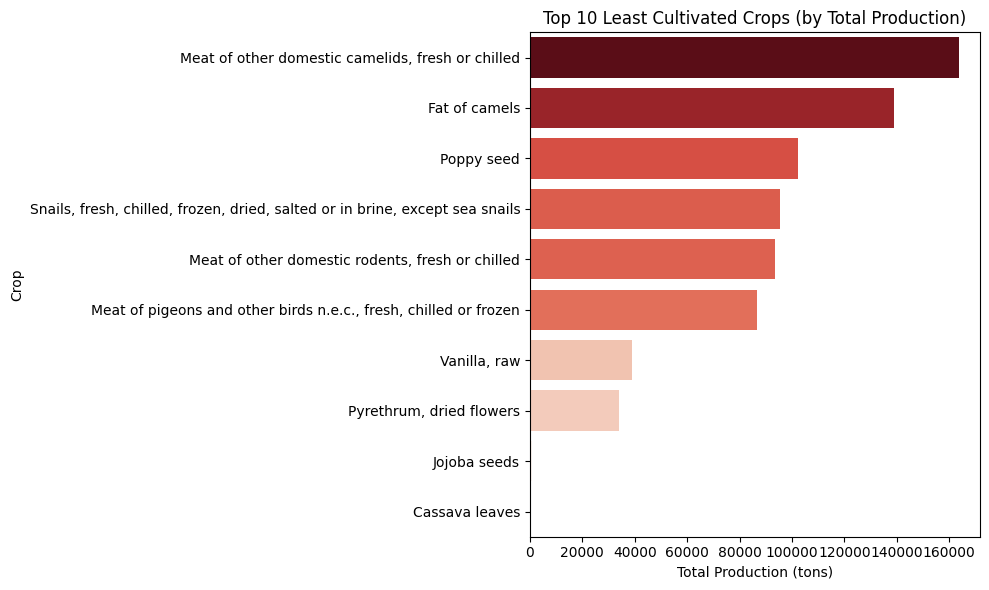

In [32]:
from sqlalchemy import create_engine

engine = create_engine(f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}')

query = """
SELECT 
    item,
    SUM(value) AS total_production
FROM crop_production
WHERE element = 'Production'
GROUP BY item
ORDER BY total_production DESC
"""

crop_distribution_df = pd.read_sql_query(query, engine)

top10_crops = crop_distribution_df.head(10)

bottom10_crops = crop_distribution_df.tail(10)

plt.figure(figsize=(10, 6))
sns.barplot(y='item', x='total_production', data=top10_crops, palette='Greens',hue='total_production', legend=False)
plt.title('Top 10 Most Cultivated Crops (by Total Production)')
plt.xlabel('Total Production (tons)')
plt.ylabel('Crop')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(y='item', x='total_production', data=bottom10_crops, palette='Reds', hue='total_production', legend=False)
plt.title('Top 10 Least Cultivated Crops (by Total Production)')
plt.xlabel('Total Production (tons)')
plt.ylabel('Crop')
plt.tight_layout()
plt.show()


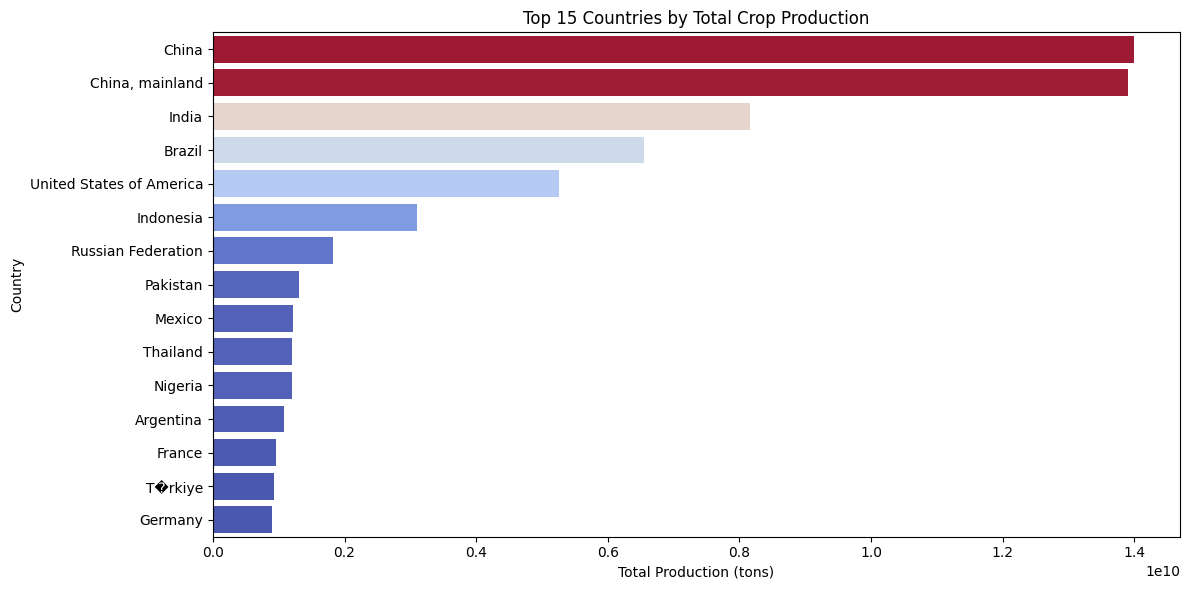

In [33]:
query = """
SELECT 
    area,
    SUM(value) AS total_production
FROM crop_production
WHERE element = 'Production'
GROUP BY area
ORDER BY total_production DESC
"""

production_by_country = pd.read_sql_query(query, engine)

top15_countries = production_by_country.head(15)

plt.figure(figsize=(12, 6))
sns.barplot(y='area', x='total_production', data=top15_countries, palette='coolwarm', hue='total_production', legend=False)
plt.title('Top 15 Countries by Total Crop Production')
plt.xlabel('Total Production (tons)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

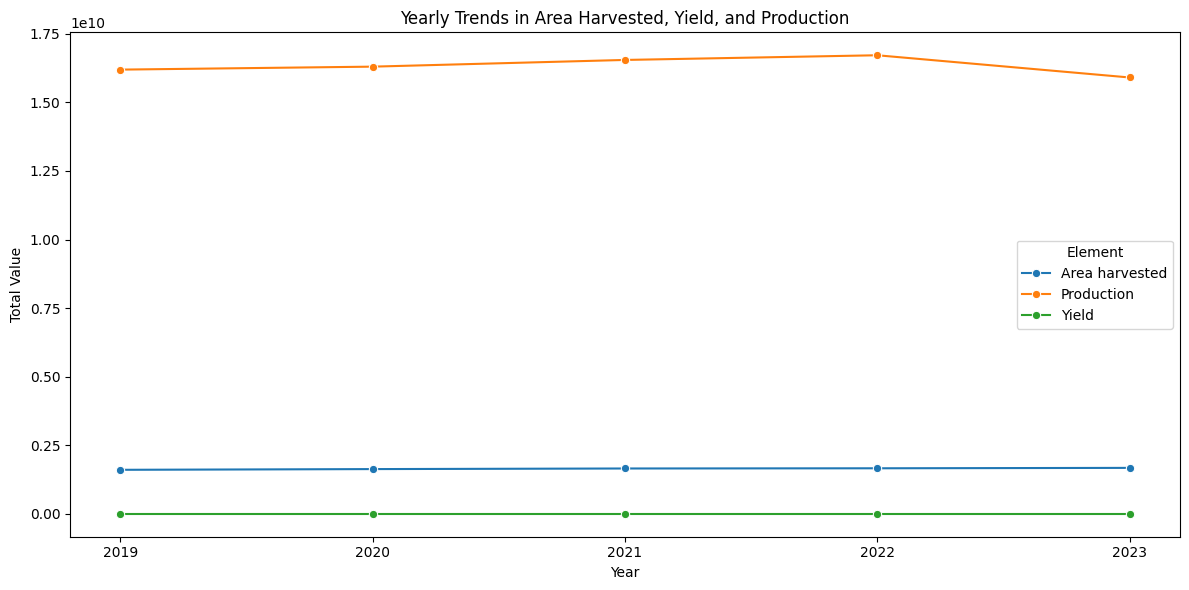

In [34]:
query = """
SELECT 
    year,
    element,
    CASE 
        WHEN element = 'Yield' THEN AVG(value)
        ELSE SUM(value)
    END AS total_value
FROM crop_production
WHERE element IN ('Area harvested', 'Yield', 'Production')
GROUP BY year, element
ORDER BY year, element
"""

yearly_trends_df = pd.read_sql_query(query, engine)

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_trends_df, x='year', y='total_value', hue='element', marker='o')
plt.title('Yearly Trends in Area Harvested, Yield, and Production')
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.legend(title='Element')
plt.xticks(sorted(yearly_trends_df['year'].unique()))

plt.tight_layout()
plt.show()

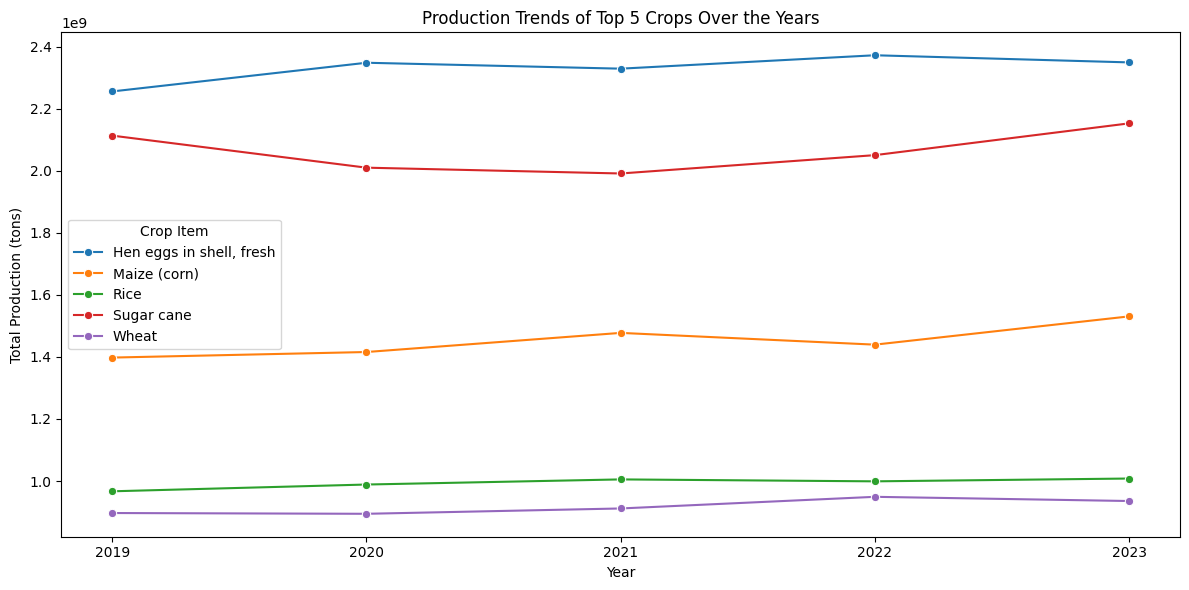

In [35]:
query = """
SELECT 
    item,
    year,
    SUM(value) AS total_production
FROM crop_production
WHERE element = 'Production'
GROUP BY item, year
HAVING COUNT(*) > 1
ORDER BY item, year
"""

crop_trends_df = pd.read_sql_query(query, engine)

top_crops = (
    crop_trends_df.groupby('item')['total_production']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

filtered_df = crop_trends_df[crop_trends_df['item'].isin(top_crops)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='year', y='total_production', hue='item', marker='o')
plt.title('Production Trends of Top 5 Crops Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Production (tons)')
plt.legend(title='Crop Item')

plt.xticks(sorted(filtered_df['year'].unique()))

plt.tight_layout()
plt.show()


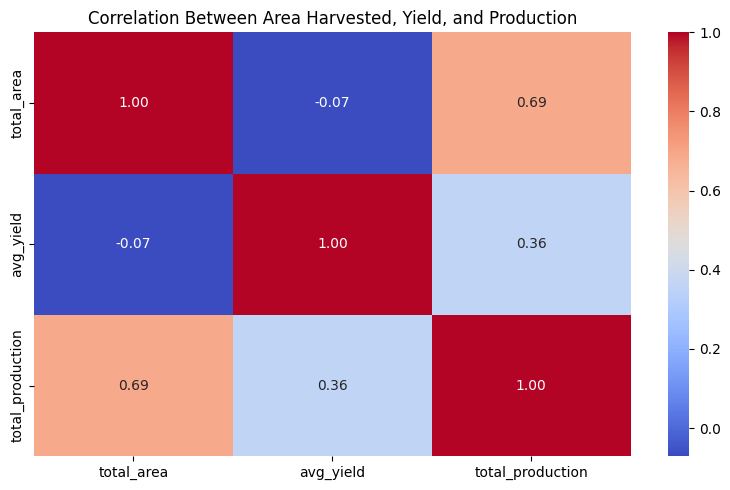

In [36]:
area_query = """
SELECT 
    item,
    year,
    SUM(value) AS total_area
FROM crop_production
WHERE element = 'Area harvested'
GROUP BY item, year
"""
area_df = pd.read_sql_query(area_query, engine)

yield_query = """
SELECT 
    item,
    year,
    AVG(value) AS avg_yield
FROM crop_production
WHERE element = 'Yield'
GROUP BY item, year
"""
yield_df = pd.read_sql_query(yield_query, engine)

production_query = """
SELECT 
    item,
    year,
    SUM(value) AS total_production
FROM crop_production
WHERE element = 'Production'
GROUP BY item, year
"""
production_df = pd.read_sql_query(production_query, engine)

merged_df = area_df.merge(yield_df, on=['item', 'year']) \
                   .merge(production_df, on=['item', 'year'])

correlation_matrix = merged_df[['total_area', 'avg_yield', 'total_production']].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Area Harvested, Yield, and Production')
plt.tight_layout()
plt.show()


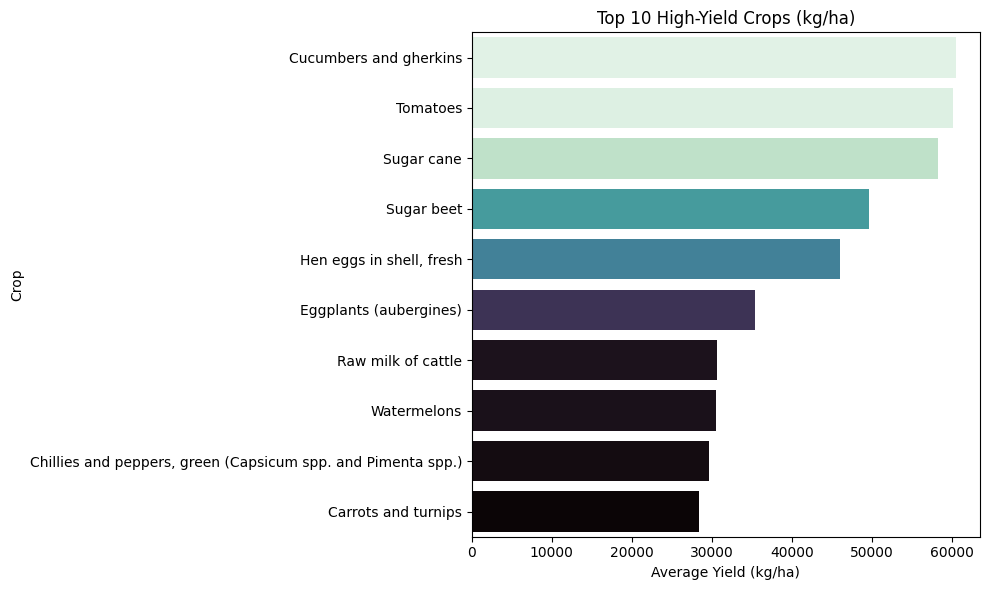

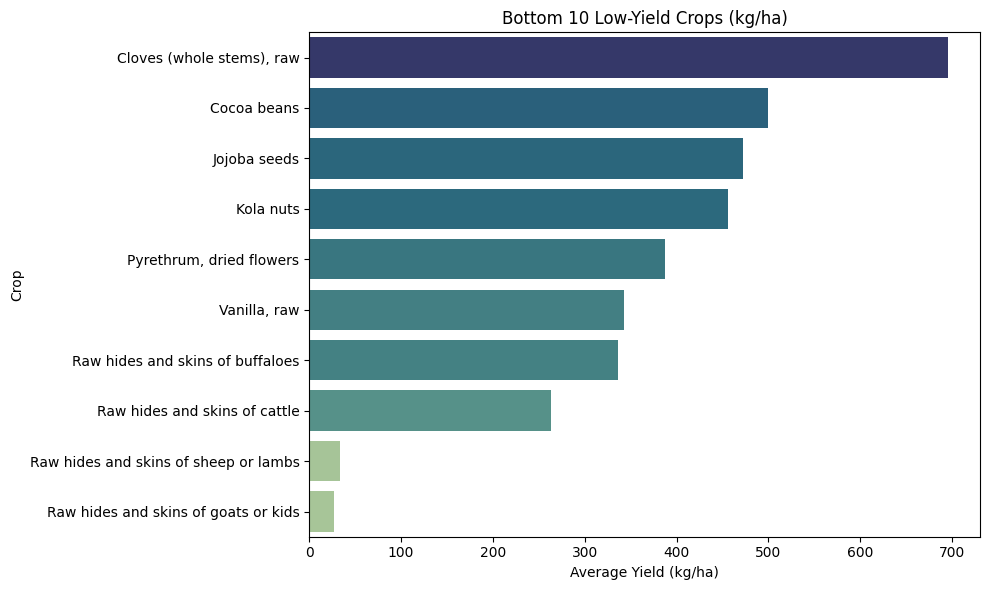

In [37]:
query = """
SELECT 
    item,
    AVG(value) AS avg_yield
FROM crop_production
WHERE element = 'Yield'
GROUP BY item
ORDER BY avg_yield DESC
"""

yield_df = pd.read_sql_query(query, engine)

top10_yield = yield_df.head(10)

bottom10_yield = yield_df.tail(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='avg_yield', y='item', data=top10_yield, palette='mako', hue='avg_yield', legend=False)
plt.title('Top 10 High-Yield Crops (kg/ha)')
plt.xlabel('Average Yield (kg/ha)')
plt.ylabel('Crop')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='avg_yield', y='item', data=bottom10_yield, palette="crest", hue='avg_yield', legend=False)
plt.title('Bottom 10 Low-Yield Crops (kg/ha)')
plt.xlabel('Average Yield (kg/ha)')
plt.ylabel('Crop')
plt.tight_layout()
plt.show()


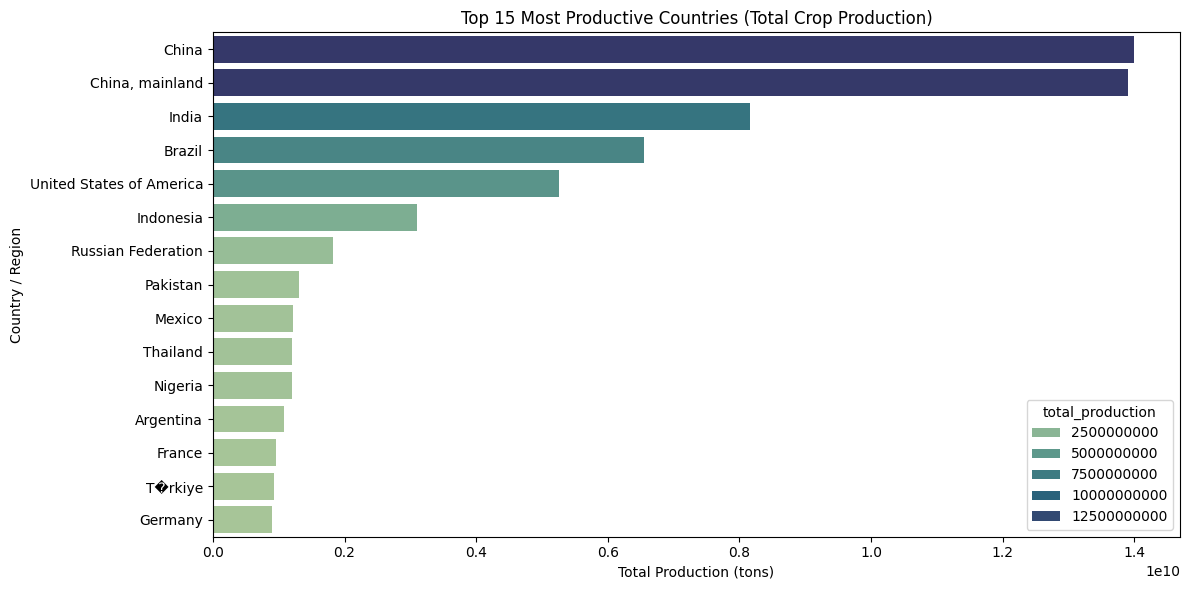

In [38]:
query = """
SELECT 
    area,
    SUM(value) AS total_production
FROM crop_production
WHERE element = 'Production'
GROUP BY area
ORDER BY total_production DESC
"""

region_production_df = pd.read_sql_query(query, engine)

top15_regions = region_production_df.head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='total_production', y='area', data=top15_regions, palette='crest', hue='total_production')
plt.title('Top 15 Most Productive Countries (Total Crop Production)')
plt.xlabel('Total Production (tons)')
plt.ylabel('Country / Region')
plt.tight_layout()
plt.show()


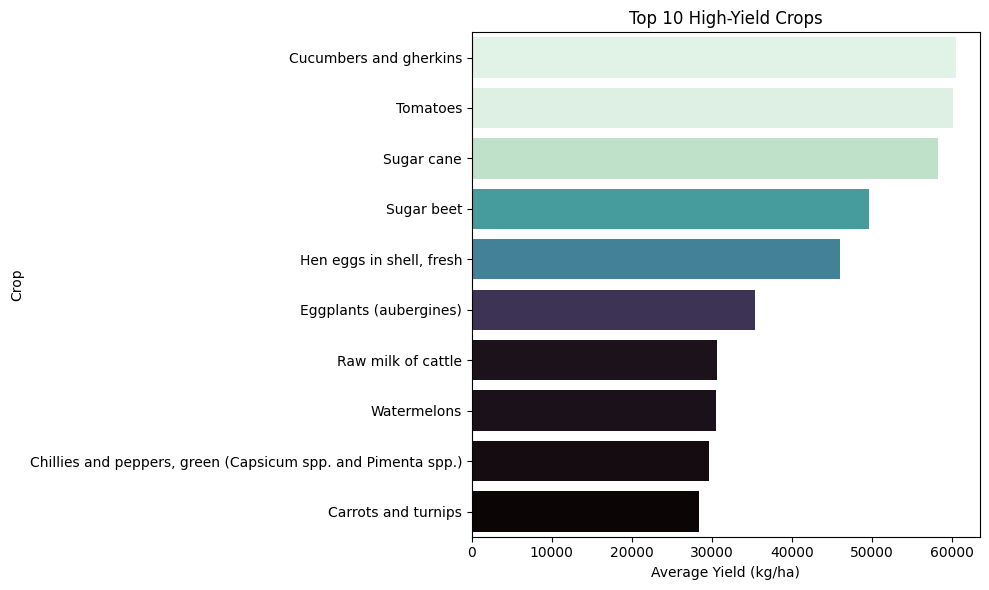

In [39]:
query_crop = """
SELECT 
    item,
    AVG(value) AS avg_yield
FROM crop_production
WHERE element = 'Yield'
GROUP BY item
ORDER BY avg_yield DESC
"""

yield_by_crop = pd.read_sql_query(query_crop, engine)

top10_crops = yield_by_crop.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='avg_yield', y='item', data=top10_crops, palette='mako', hue='avg_yield', legend=False)
plt.title('Top 10 High-Yield Crops')
plt.xlabel('Average Yield (kg/ha)')
plt.ylabel('Crop')
plt.tight_layout()
plt.show()


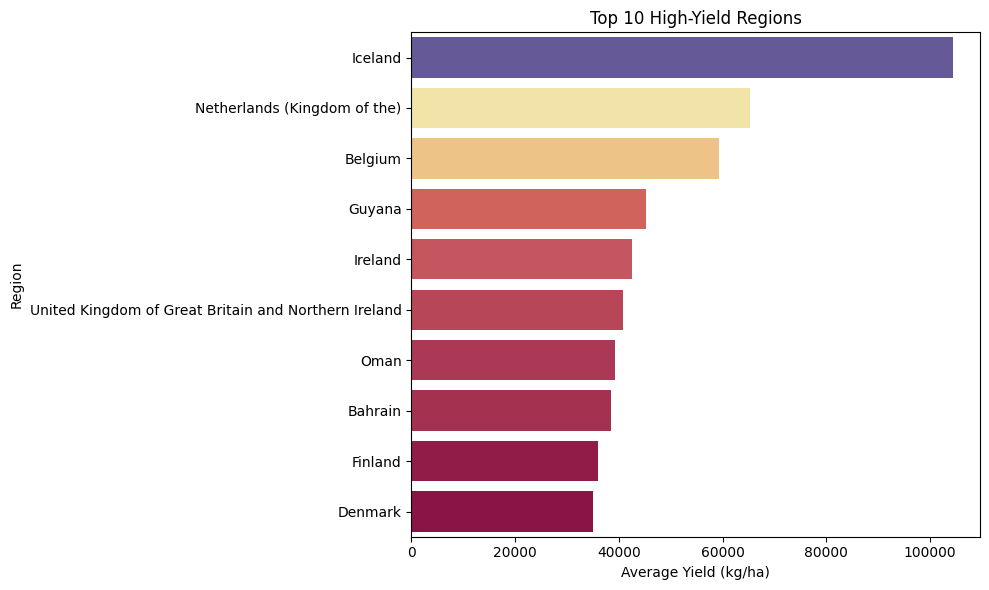

In [40]:
query_region = """
SELECT 
    area,
    AVG(value) AS avg_yield
FROM crop_production
WHERE element = 'Yield'
GROUP BY area
ORDER BY avg_yield DESC
"""

yield_by_region = pd.read_sql_query(query_region, engine)

top10_regions = yield_by_region.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='avg_yield', y='area', data=top10_regions, palette='Spectral', hue='avg_yield', legend=False)
plt.title('Top 10 High-Yield Regions')
plt.xlabel('Average Yield (kg/ha)')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


Correlation between productivity ratio and average yield: 0.9306


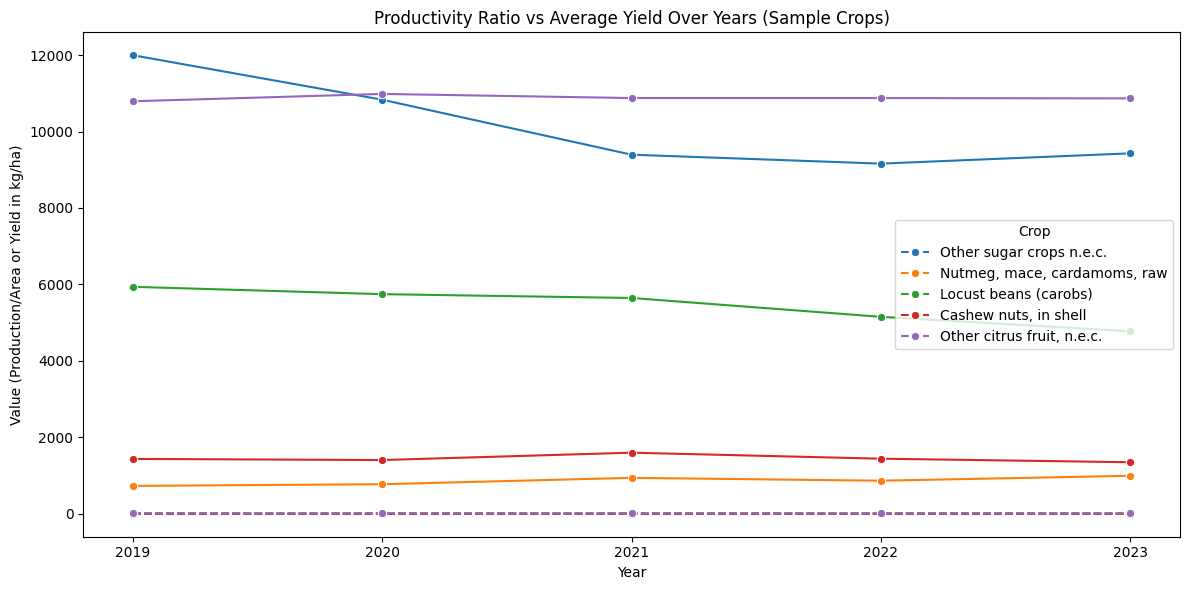

In [41]:
production_query = """
SELECT
    item,
    year,
    SUM(value) AS total_production
FROM crop_production
WHERE element = 'Production'
GROUP BY item, year
"""

production_df = pd.read_sql_query(production_query, engine)

area_query = """
SELECT
    item,
    year,
    SUM(value) AS total_area
FROM crop_production
WHERE element = 'Area harvested'
GROUP BY item, year
"""

area_df = pd.read_sql_query(area_query, engine)

merged_df = pd.merge(production_df, area_df, on=['item', 'year'])

merged_df['productivity_ratio'] = merged_df['total_production'] / merged_df['total_area']

yield_query = """
SELECT
    item,
    year,
    AVG(value) AS avg_yield
FROM crop_production
WHERE element = 'Yield'
GROUP BY item, year
"""

yield_df = pd.read_sql_query(yield_query, engine)

final_df = pd.merge(merged_df, yield_df, on=['item', 'year'])

corr = final_df[['productivity_ratio', 'avg_yield']].corr().iloc[0,1]
print(f"Correlation between productivity ratio and average yield: {corr:.4f}")

sample_crops = final_df['item'].value_counts().head(5).index.tolist()
plot_df = final_df[final_df['item'].isin(sample_crops)]

plt.figure(figsize=(12, 6))

sns.lineplot(data=plot_df, x='year', y='productivity_ratio', hue='item', marker='o', linestyle='--')

sns.lineplot(data=plot_df, x='year', y='avg_yield', hue='item', marker='o', legend=False)

plt.title('Productivity Ratio vs Average Yield Over Years (Sample Crops)')
plt.xlabel('Year')
plt.ylabel('Value (Production/Area or Yield in kg/ha)')
plt.legend(title='Crop')
plt.xticks(sorted(filtered_df['year'].unique()))

plt.tight_layout()
plt.show()

Pearson Correlation: -0.03
Spearman Correlation: -0.11


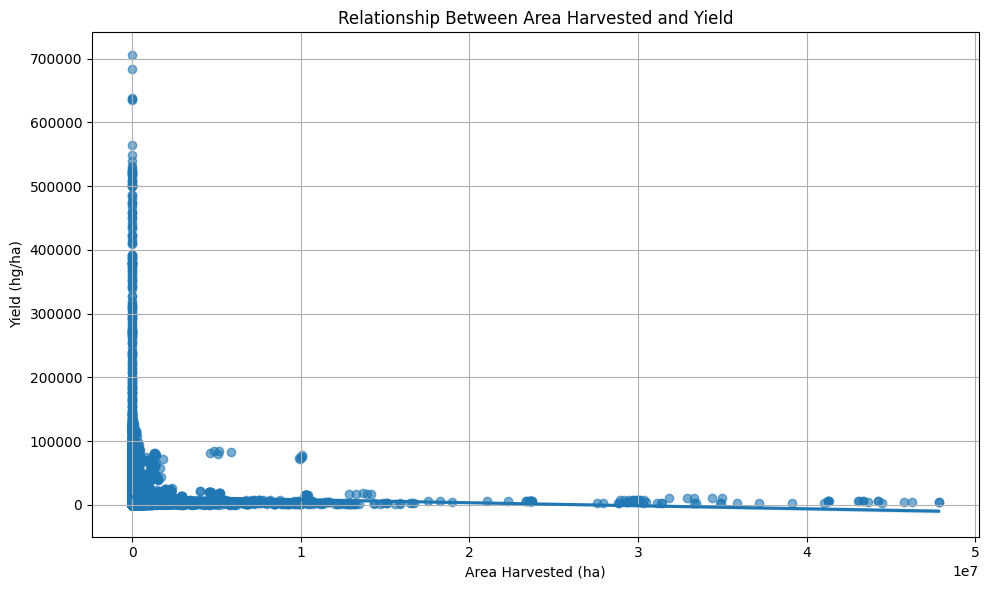

In [42]:
query= """
SELECT 
    area,
    item,
    year,
    SUM(CASE WHEN element = 'Area harvested' THEN value ELSE 0 END) AS area_harvested,
    SUM(CASE WHEN element = 'Yield' THEN value ELSE 0 END) AS yield
FROM crop_production
WHERE element IN ('Area harvested', 'Yield')
GROUP BY area, item, year
HAVING 
    SUM(CASE WHEN element = 'Area harvested' THEN value ELSE 0 END) > 0 AND
    SUM(CASE WHEN element = 'Yield' THEN value ELSE 0 END) > 0
ORDER BY year;
"""

df = pd.read_sql_query(query, engine)

# Drop rows with 0 or null values
df = df[(df['area_harvested'] > 0) & (df['yield'] > 0)].copy()

# Correlation
pearson_corr = df['area_harvested'].corr(df['yield'], method='pearson')
spearman_corr = df['area_harvested'].corr(df['yield'], method='spearman')
print(f"Pearson Correlation: {pearson_corr:.2f}")
print(f"Spearman Correlation: {spearman_corr:.2f}")

# Regression Plot
plt.figure(figsize=(10, 6))
sns.regplot(x='area_harvested', y='yield', data=df, scatter_kws={'alpha':0.6})
plt.title('Relationship Between Area Harvested and Yield')
plt.xlabel('Area Harvested (ha)')
plt.ylabel('Yield (hg/ha)')
plt.grid(True)
plt.tight_layout()
plt.show()



Total Anomalies Detected: 969


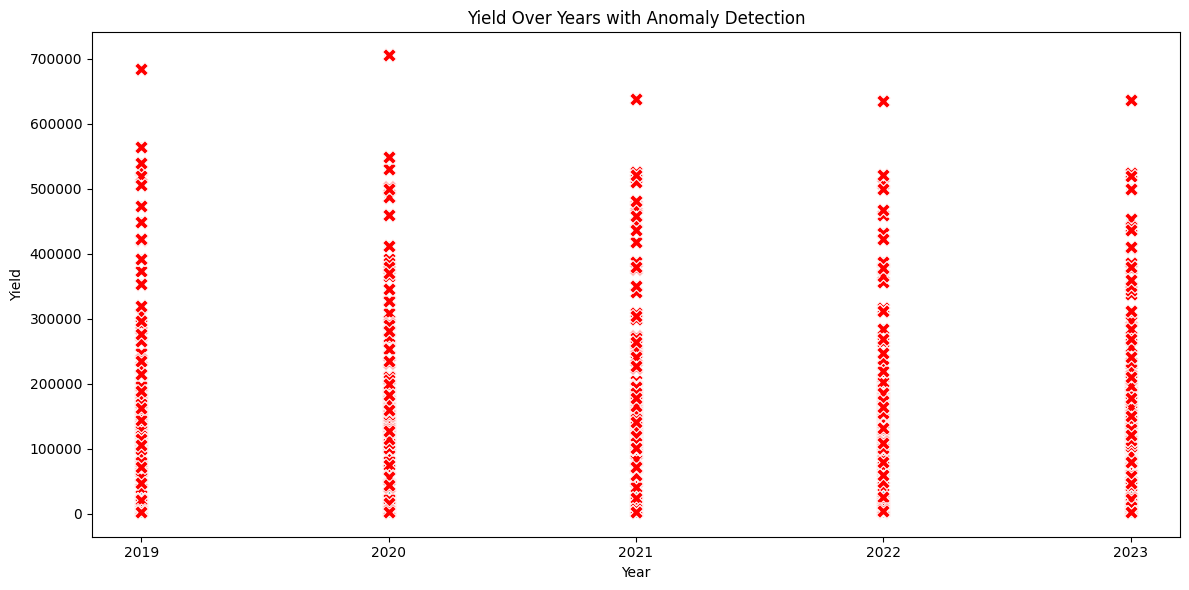

In [43]:
query = """
SELECT 
    area,
    item,
    year,
    SUM(CASE WHEN element = 'Production' THEN value ELSE 0 END) AS production,
    SUM(CASE WHEN element = 'Yield' THEN value ELSE 0 END) AS yield
FROM crop_production
WHERE element IN ('Production', 'Yield')
GROUP BY area, item, year
HAVING 
    SUM(CASE WHEN element = 'Production' THEN value ELSE 0 END) > 0 AND
    SUM(CASE WHEN element = 'Yield' THEN value ELSE 0 END) > 0
ORDER BY year;

"""

from scipy.stats import zscore

df = pd.read_sql_query(query, engine)
df = df[(df['production'] > 0) & (df['yield'] > 0)].copy()

# Z-scores
df['production_z'] = zscore(df['production'])
df['yield_z'] = zscore(df['yield'])

# Flagging anomalies (Z-score > 3 or < -3)
anomalies = df[(df['production_z'].abs() > 3) | (df['yield_z'].abs() > 3)]

print(f"Total Anomalies Detected: {len(anomalies)}")

# Plot with anomalies
plt.figure(figsize=(12, 6))

# Plot normal points (colored by item)
sns.scatterplot(data=df, x='year', y='yield', hue='item', alpha=0.5, legend=False)

# Plot anomalies as red Xs
sns.scatterplot(
    data=anomalies,
    x='year',
    y='yield',
    color='red',
    marker='X',
    s=100,
    label='Anomalies',  # Only one manual label
    legend=False
)

plt.title('Yield Over Years with Anomaly Detection')
plt.xlabel('Year')
plt.ylabel('Yield')
plt.xticks(sorted(filtered_df['year'].unique()))
plt.tight_layout()
plt.show()

### Model Training and Prediction

In [44]:
engine = create_engine(f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}')

crop_query = """
SELECT * FROM crop_production
"""

crop_df = pd.read_sql_query(crop_query, engine)

In [45]:
pivot_df = crop_df.pivot_table(
    index=['area', 'item', 'year'],
    columns='element',
    values='value',
    aggfunc='first'
).reset_index()

pivot_df.rename(columns={
    'area': 'Area',
    'item': 'Item',
    'year': 'Year',
    'Area harvested': 'Area_Harvested',
}, inplace=True)
pivot_df = pivot_df[['Area', 'Item', 'Year', 'Area_Harvested', 'Yield', 'Production']].copy()

In [46]:
pivot_df_clean = pivot_df.dropna(subset=['Area_Harvested', 'Yield', 'Production'])
pivot_df_clean.isnull().sum()

element
Area              0
Item              0
Year              0
Area_Harvested    0
Yield             0
Production        0
dtype: int64

In [47]:
X = pivot_df_clean.drop(['Production', 'Yield'], axis=1)
y = pivot_df_clean['Production']

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [0, 1])
    ],
    remainder='passthrough'
)

X_train_encoded = ct.fit_transform(X_train)
X_test_encoded = ct.transform(X_test)

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linear_model = LinearRegression()
linear_model.fit(X_train_encoded, y_train)

y_pred_test = linear_model.predict(X_test_encoded)
y_pred_train = linear_model.predict(X_train_encoded)

r_test = r2_score(y_test, y_pred_test)
r_train = r2_score(y_train, y_pred_train)

print("Linear Model Evaluation:")
print(f"R2 Test Score : {r_test:.4f}")
print(f"R2 Train Score : {r_train:.4f}")

Linear Model Evaluation:
R2 Test Score : 0.4004
R2 Train Score : 0.4743


In [51]:
from sklearn.tree import DecisionTreeRegressor
decisiontree_model = DecisionTreeRegressor(random_state=0)
decisiontree_model.fit(X_train_encoded, y_train)

y_pred_test = decisiontree_model.predict(X_test_encoded)
y_pred_train = decisiontree_model.predict(X_train_encoded)

r_test = r2_score(y_test, y_pred_test)
r_train = r2_score(y_train, y_pred_train)

print("DecisionTree Model Evaluation:")
print(f"R2 Test Score : {r_test:.4f}")
print(f"R2 Train Score : {r_train:.4f}")

DecisionTree Model Evaluation:
R2 Test Score : 0.9949
R2 Train Score : 1.0000


In [52]:
from sklearn.ensemble import RandomForestRegressor

randomforest = RandomForestRegressor(random_state=0, n_estimators=100)
randomforest.fit(X_train_encoded, y_train)

y_pred_test = randomforest.predict(X_test_encoded)
y_pred_train = randomforest.predict(X_train_encoded)

r_test = r2_score(y_test, y_pred_test)
r_train = r2_score(y_train, y_pred_train)

print("RandomForest Model Evaluation:")
print(f"R2 Test Score : {r_test:.4f}")
print(f"R2 Train Score : {r_train:.4f}")

RandomForest Model Evaluation:
R2 Test Score : 0.9826
R2 Train Score : 0.9946
